In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time


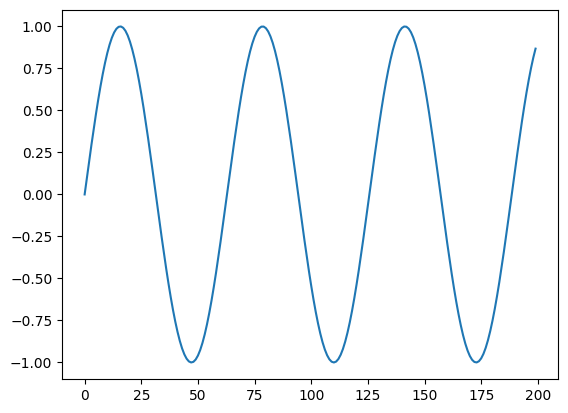

In [73]:
series = np.sin(0.1 * np.arange(200))  # + np.random.normal(0, 0.3, 200)

plt.plot(series)
plt.show()

In [74]:
# Build the dataset

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)

    # For one-step-ahead prediction
    y = series[t + T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)

# Each row of the X matrix holds the inputs of a single training sample
# And we have 190 such sample (because there are 200 time points and T=10 plus one step ahead)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


Epoch   1/80 | Train Loss: 0.541285 | Val Loss: 0.073441
Epoch  10/80 | Train Loss: 0.069498 | Val Loss: 0.007968
Epoch  20/80 | Train Loss: 0.044913 | Val Loss: 0.037989
Epoch  30/80 | Train Loss: 0.007159 | Val Loss: 0.009555
Epoch  40/80 | Train Loss: 0.001373 | Val Loss: 0.003644
Epoch  50/80 | Train Loss: 0.000134 | Val Loss: 0.000735
Epoch  60/80 | Train Loss: 0.000249 | Val Loss: 0.000639
Epoch  70/80 | Train Loss: 0.000159 | Val Loss: 0.000202
Epoch  80/80 | Train Loss: 0.000106 | Val Loss: 0.000041
Training completed in 0.01 seconds.


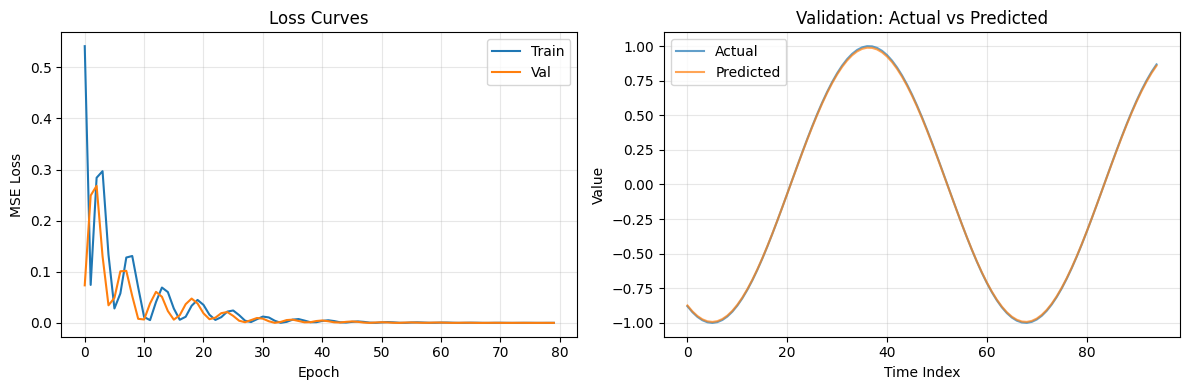

Next-step forecast (PyTorch ARLinear, device=cpu): 0.8581


In [75]:
# PyTorch translation of Keras autoregressive linear model (GPU-enabled)
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure reproducibility
torch.manual_seed(0)

# Select device (GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

device = torch.device("cpu")

# Prepare tensors and move to device
X_tensor = torch.from_numpy(X).float().to(device)  # shape (N, T)
Y_tensor = torch.from_numpy(Y).float().unsqueeze(1).to(device)  # shape (N, 1)

# Train / validation split (same as Keras code)
split = N // 2
X_train, Y_train = X_tensor[:split], Y_tensor[:split]
X_val, Y_val = X_tensor[split:], Y_tensor[split:]

# Define simple linear autoregressive model: y_t = w^T x + b
class ARLinear(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

model = ARLinear(T).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Keep epochs modest; original request was 80 (we previously overshot). GPU makes this fast.
epochs = 80
train_losses = []
val_losses = []


start_time = time()

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, Y_val).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

end_time = time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Final evaluation and visualization

model.eval()

with torch.no_grad():
    val_pred_cpu = model(X_val).squeeze(1).detach().cpu().numpy()
    Y_val_cpu = Y_val.squeeze(1).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(Y_val_cpu, label='Actual', alpha=0.7)
plt.plot(val_pred_cpu, label='Predicted', alpha=0.7)
plt.title('Validation: Actual vs Predicted')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Example of using model for next-step forecast on last window
last_window = X_tensor[-1:].clone()
with torch.no_grad():
    next_pred = model(last_window).item()
print(f"Next-step forecast (PyTorch ARLinear, device={device}): {next_pred:.4f}")


In [76]:
# Wrong forecast using true targets

validation_target = Y[-split:]
validation_predictions = []

# Index of first validation input
i = split # - N // 2

while len(validation_predictions) < len(validation_target):
    p = model(X_tensor[i]).detach().numpy()[0]
    i += 1

    validation_predictions.append(p)


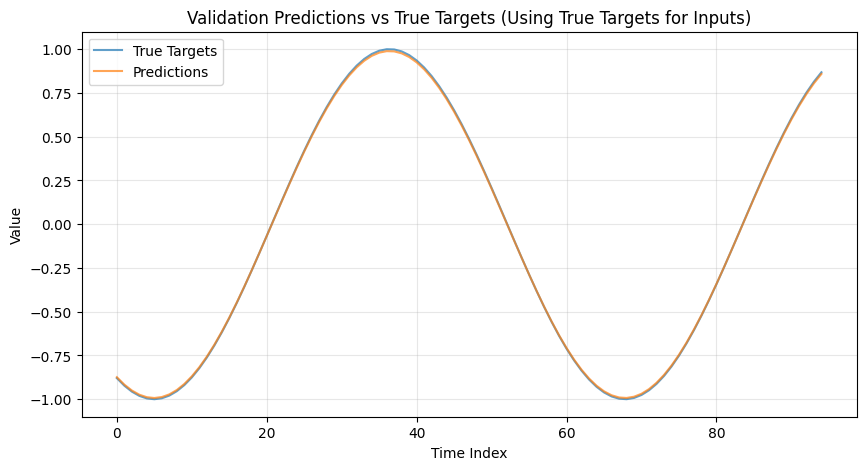

In [77]:
# Plot the validation predictions against true targets

plt.figure(figsize=(10, 5))
plt.plot(validation_target, label='True Targets', alpha=0.7)
plt.plot(validation_predictions, label='Predictions', alpha=0.7)
plt.title('Validation Predictions vs True Targets (Using True Targets for Inputs)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Now do the correct way to forecast using own predictions

validation_target = Y[-split:]
validation_predictions_correct = []

i = split

x_input = X_tensor[i].unsqueeze(0)

while len(validation_predictions_correct) < len(validation_target) - 1:
    p = model(x_input)
    # Subsequent inputs use own predictions


    validation_predictions_correct.append(p.detach().numpy()[0])

    i += 1
    x_prev = X_tensor[i][:-1].unsqueeze(0)
    x_input = torch.cat([x_prev, p], dim=1)


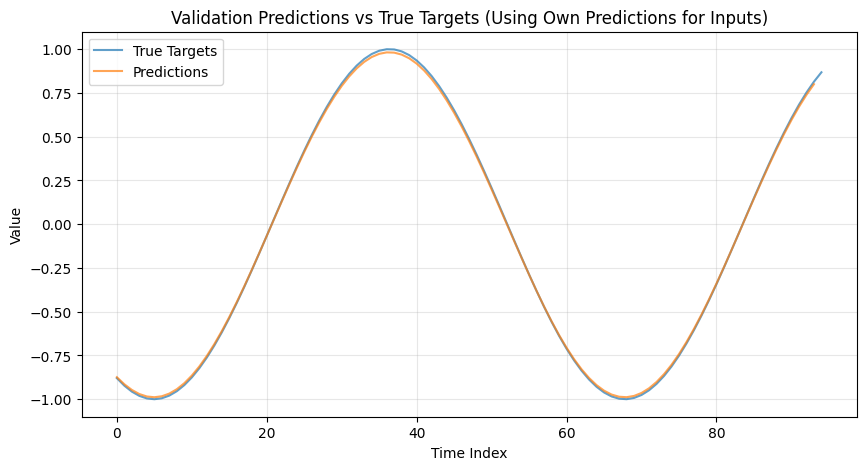

In [80]:
# Plot true vs predicted values

plt.figure(figsize=(10, 5))
plt.plot(validation_target, label='True Targets', alpha=0.7)
plt.plot(validation_predictions_correct, label='Predictions', alpha=0.7)
plt.title('Validation Predictions vs True Targets (Using Own Predictions for Inputs)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [71]:
validation_predictions

[np.float32(-0.78232586),
 np.float32(-1.1228359),
 np.float32(-0.8874901),
 np.float32(-0.9159947),
 np.float32(-0.8069861),
 np.float32(-0.7504251),
 np.float32(-0.8836248),
 np.float32(-0.8063103),
 np.float32(-0.78436357),
 np.float32(-0.6279256),
 np.float32(-0.60798377),
 np.float32(-0.8643303),
 np.float32(-0.677243),
 np.float32(-0.84282905),
 np.float32(-0.84167063),
 np.float32(-0.73437685),
 np.float32(-0.7306407),
 np.float32(-0.4796224),
 np.float32(-0.40390584),
 np.float32(-0.18789986),
 np.float32(-0.0013365401),
 np.float32(-0.033611108),
 np.float32(0.2554403),
 np.float32(0.19159828),
 np.float32(0.117726296),
 np.float32(0.2666008),
 np.float32(0.49714175),
 np.float32(0.24205147),
 np.float32(0.57747996),
 np.float32(0.74032634),
 np.float32(0.8443933),
 np.float32(0.6903203),
 np.float32(0.92032915),
 np.float32(1.1360022),
 np.float32(1.0088166),
 np.float32(1.0399885),
 np.float32(1.2610593),
 np.float32(1.1694224),
 np.float32(1.0706578),
 np.float32(0.86993957

In [72]:
validation_predictions_correct

[array([-0.78232586], dtype=float32),
 array([-0.91030127], dtype=float32),
 array([-0.90594697], dtype=float32),
 array([-0.8063372], dtype=float32),
 array([-0.81184226], dtype=float32),
 array([-0.85552305], dtype=float32),
 array([-0.8879557], dtype=float32),
 array([-0.8392365], dtype=float32),
 array([-0.6518654], dtype=float32),
 array([-0.6693564], dtype=float32),
 array([-0.49132752], dtype=float32),
 array([-0.6537308], dtype=float32),
 array([-0.66810805], dtype=float32),
 array([-0.70262057], dtype=float32),
 array([-0.75839394], dtype=float32),
 array([-0.7714604], dtype=float32),
 array([-0.7422572], dtype=float32),
 array([-0.59070027], dtype=float32),
 array([-0.6361725], dtype=float32),
 array([-0.38107225], dtype=float32),
 array([-0.11325859], dtype=float32),
 array([0.02572915], dtype=float32),
 array([0.24926998], dtype=float32),
 array([0.3262817], dtype=float32),
 array([0.20890683], dtype=float32),
 array([0.17729555], dtype=float32),
 array([0.19430523], dtype=

## Markdown

In [ ]:
# Load the data (as before)

